In [2]:
from pathlib import Path
import os
from os import path as osp
import json

import cv2
import lancedb
import webvtt
import whisper
from moviepy import *
from mistralai import Mistral
from dotenv import load_dotenv
from langchain_core.runnables import (
    RunnableParallel, 
    RunnablePassthrough, 
    RunnableLambda
)
#conda install -c conda-forge ffmpeg

from utils import encode_image
from preprocess.preprocessing import (
    extract_and_save_frames_and_metadata,
)
from crud.vector_store import (
    MultimodalLanceDB,
)
from preprocess.embedding import (
    BridgeTowerEmbeddings,
)

C:\Users\User\AppData\Local\Temp\ipykernel_41796\2428436760.py:27: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from preprocess.embedding import (


In [33]:
# Load environment variables
load_dotenv('local.env')

True

In [2]:
def load_json_file(file_path):
    # Open the JSON file in read mode
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

### Step 1: Preprocessing

The below code snippet is needed only if you are downloading the video the internet.

In [4]:

# first video's url
video_url = "https://www.youtube.com/watch?v=7Hcg-rLYwdM"

video_dir = "./shared_data/videos/video1"

# download Youtube video to ./shared_data/videos/video1
video_filepath = download_video(video_url, video_dir)

# download Youtube video's subtitle to ./shared_data/videos/video1
video_transcript_filepath = get_transcript_vtt(video_url, video_dir)


Getting video information for https://www.youtube.com/watch?v=7Hcg-rLYwdM


In [14]:
extracted_frames_path = osp.join(video_dir, 'extracted_frame')

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(video_dir).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata(
                video_filepath, 
                video_transcript_filepath,
                extracted_frames_path,
                video_dir,
            )

In [15]:
metadatas[:4]

[{'extracted_frame_path': './shared_data/videos/video1\\extracted_frame\\frame_0.jpg',
  'transcript': "As I look back on the the mission that we've had here",
  'video_segment_id': 0,
  'video_path': './shared_data/videos/video1\\Welcome back to Planet Earth.mp4',
  'mid_time_ms': 5249.5},
 {'extracted_frame_path': './shared_data/videos/video1\\extracted_frame\\frame_1.jpg',
  'transcript': "on the International Space Station, I'm proud to have been a part of much of",
  'video_segment_id': 1,
  'video_path': './shared_data/videos/video1\\Welcome back to Planet Earth.mp4',
  'mid_time_ms': 8719.0},
 {'extracted_frame_path': './shared_data/videos/video1\\extracted_frame\\frame_2.jpg',
  'transcript': 'the science activities that happened over the last',
  'video_segment_id': 2,
  'video_path': './shared_data/videos/video1\\Welcome back to Planet Earth.mp4',
  'mid_time_ms': 12119.0},
 {'extracted_frame_path': './shared_data/videos/video1\\extracted_frame\\frame_3.jpg',
  'transcript': 

In [16]:
# collect transcripts and image paths
video_trans = [vid['transcript'] for vid in metadatas]
video_img_path = [vid['extracted_frame_path'] for vid in metadatas]


In [17]:
# for video1, we pick n = 7
n = 7
updated_video_trans = [
 ' '.join(video_trans[i-int(n/2) : i+int(n/2)]) if i-int(n/2) >= 0 else
 ' '.join(video_trans[0 : i + int(n/2)]) for i in range(len(video_trans))
]
# also need to update the updated transcripts in metadata
for i in range(len(updated_video_trans)):
    metadatas[i]['transcript'] = updated_video_trans[i]


In [18]:
print(f'A transcript example before update:\n"{video_trans[3]}"')
print()
print(f'After update:\n"{updated_video_trans[3]}"')

A transcript example before update:
"two months."

After update:
"As I look back on the the mission that we've had here on the International Space Station, I'm proud to have been a part of much of the science activities that happened over the last two months. The view is always amazing I didn't think I would do another"


In [19]:
len(updated_video_trans)

26

### Step 2 and 3: Generate Embeddings and Populate LanceDB

In [20]:
# declare host file
LANCEDB_HOST_FILE = "./shared_data/.lancedb"
# declare table name
TBL_NAME = "vectorstore"
# initialize vectorstore
db = lancedb.connect(LANCEDB_HOST_FILE)

In [23]:
# initialize an BridgeTower embedder 
embedder = BridgeTowerEmbeddings()

_ = MultimodalLanceDB.from_text_image_pairs(
    texts=updated_video_trans,
    image_paths=video_img_path,
    embedding=embedder,
    metadatas=metadatas,
    connection=db,
    table_name=TBL_NAME,
    mode="overwrite", 
)

The length of texts is 26
Embedding 26 image-text pairs...


Processing pairs:   0%|          | 0/26 [00:00<?, ?it/s]Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing pairs:   4%|▍         | 1/26 [00:21<08:58, 21.54s/it]Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing pairs:   8%|▊         | 2/26 [00:42<08:27, 21.16s/it]Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on

Adding 26 text-image pairs to the vectorstore...


In [24]:
# open a connection to table TBL_NAME
tbl = db.open_table('vectorstore')

#print(f"There are {tbl.to_pandas().shape[0]} rows in the table")
# display the first 3 rows of the table
tbl.to_pandas().head(3)

,vector,id,text,image_path,metadata
0,"[0.08138844, 0.01215915, 0.021530587, -0.07548...",6e7bc6a1-ca2c-45ae-a173-5bfabda095f0,As I look back on the the mission that we've h...,./shared_data/videos/video1\extracted_frame\fr...,{'extracted_frame_path': './shared_data/videos...
1,"[0.07235768, 0.0043346197, 0.029056126, -0.081...",b5f12aed-de05-4b12-9626-173e5c79a173,As I look back on the the mission that we've h...,./shared_data/videos/video1\extracted_frame\fr...,{'extracted_frame_path': './shared_data/videos...
2,"[0.04844188, 0.017217126, 0.031164195, -0.0950...",b81a44b1-e82a-42f6-a57e-c778dbbfae82,As I look back on the the mission that we've h...,./shared_data/videos/video1\extracted_frame\fr...,{'extracted_frame_path': './shared_data/videos...


### Step 4: Retrieve relevant Embeddings

In [25]:
## Creating a LanceDB vector store object 
vectorstore = MultimodalLanceDB(
    uri=LANCEDB_HOST_FILE, 
    embedding=embedder, 
    table_name=TBL_NAME
)

### creating a retriever for the vector store
### with search_type="similarity" and search_kwargs={"k": 1} 
retriever_module = vectorstore.as_retriever(
    search_type='similarity', 
    search_kwargs={"k": 3}
)

In [26]:
def display_retrieved_results(results):
    print(f'There is/are {len(results)} retrieved result(s)')
    for i, res in enumerate(results):
        print(f'The caption of the {str(i+1)}-th retrieved result is:\n"{res.page_content}"')
        display(Image.open(res.metadata['extracted_frame_path']))  # Fixed access to metadata
        print("------------------------------------------------------------")

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There is/are 3 retrieved result(s)
The caption of the 1-th retrieved result is:
"two months. The view is always amazing I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a a wonderful mission."


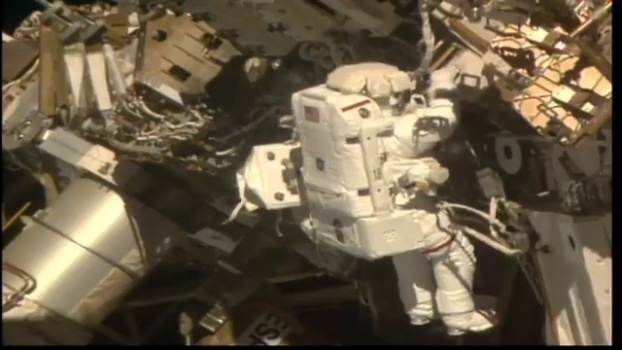

------------------------------------------------------------
The caption of the 2-th retrieved result is:
"The view is always amazing I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a a wonderful mission. Does the 10th one feel like the first one?"


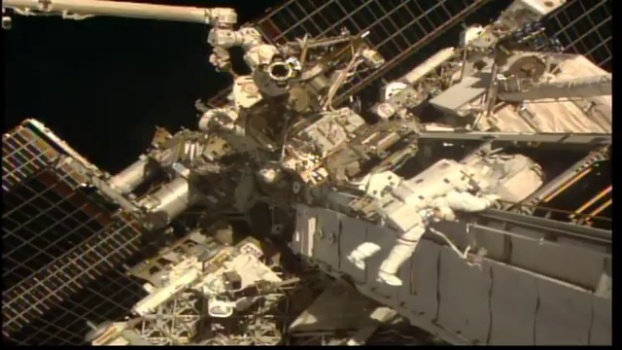

------------------------------------------------------------
The caption of the 3-th retrieved result is:
"the science activities that happened over the last two months. The view is always amazing I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a"


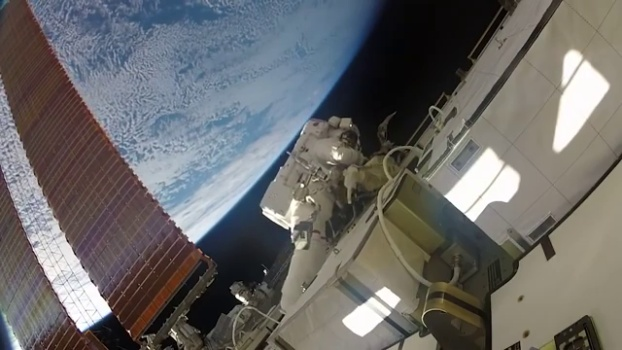

------------------------------------------------------------


In [28]:
query = (
        "an astronaut's spacewalk with an amazing view of the earth"
)
results = retriever_module.invoke(query)
display_retrieved_results(results)

### Step 5: Prompt Augmentation

In [29]:
def prompt_processing(input):
    # get the retrieved results and user's query
    retrieved_results = input['retrieved_results']
    user_query = input['user_query']
    
    # get the first retrieved result by default
    retrieved_results = retrieved_results[0]
    prompt_template = (
      "The transcript associated with the image is '{transcript}'. "
      "{user_query}"
    )
    
    # get all metadata of the retrieved video segment
    retrieved_metadata = retrieved_results.metadata

    # get the corresponding transcript
    transcript = retrieved_metadata['transcript']
    # get the extracted frame
    frame_path = retrieved_metadata['extracted_frame_path']
    
    return {
        'prompt': prompt_template.format(
            transcript=transcript, 
            user_query=user_query
        ),
        'frame_path' : frame_path
    }

### Step 6: LVLM Inference

In [35]:
def lvlm_inference(input):

    # get the retrieved results and user's query
    lvlm_prompt = input['prompt']
    frame_path = input['frame_path']
    
    
    # Retrieve the API key from environment variables
    api_key = os.getenv("MISTRAL_API_KEY")
    
    # Initialize the Mistral client
    client = Mistral(api_key=api_key)

    base64_image = encode_image(frame_path)

    # Define the messages for the chat
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": lvlm_prompt
                },
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{base64_image}" 
                }
            ]
        }
    ]

    # Get the chat response
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages
    )

    # Print the content of the response
    return chat_response.choices[0].message.content

### Step 7: Put it all together

In [38]:
# Create a Langchain RunnableLambda of function prompt_processing
prompt_processing_module = RunnableLambda(prompt_processing)

# Create a Langchain RunnableLambda of function lvlm_inference
lvlm_inference_module = RunnableLambda(lvlm_inference)

# Combine all the modules into a chain 
mm_rag_chain = (
    RunnableParallel({
        "retrieved_results": retriever_module , 
        "user_query": RunnablePassthrough()
    }) 
    | prompt_processing_module
    | lvlm_inference_module
)

query = "What do the astronauts feel about their work?"

# Invoke the Multimodal RAG system with a query
final_text_response1 = mm_rag_chain.invoke(query)

# Display the results
print(f"USER Query: {query}")
print(f"MM-RAG Response: {final_text_response1}")

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


USER Query: What do the astronauts feel about their work?
MM-RAG Response: The astronauts feel proud about their work. The transcript states that as they look back on their mission on the International Space Station, they are proud to have been a part of much of the science activities that happened over the last two months.
